# Generating synthetic time series for PanTaGruEl

PanTaGruEl is a model of the European high-voltage network. It contains nearly 4000 nodes for which synthetic time series must be created. This notebooks describes the procedure.

In [1]:
import sys
sys.path.append('../TimeSeries/')

import time_series as ts
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt

## Loads

### Get a list of loads with a weigth by country 

The Julia package `TemperateOptimalPowerFlow.jl` can be used to generate a list of all loads in PanTaGruEl, together with some relevant information such as:
- the country in which the load is placed
- a weight indicating how much of the country's total load should be assigned to that particular load.

This list is stored in a CSV file that can be fetched with Pandas:

In [2]:
loads_info = pd.read_csv('data/pantagruel_load_info.csv')
loads_info

,id,country,load_prop,name
0,3935,DE,0.002204,Unnamed 1340
1,2243,FR,0.000443,Vallorcine
2,1881,FR,0.001275,Mallemort
3,1907,FR,0.000635,Breuil
4,2923,FR,0.000650,La Justice
...,...,...,...,...
3993,3028,ES,0.000088,Conso
3994,563,ES,0.005850,Sanchinarro
3995,732,DK,0.000705,Unnamed 199
3996,3276,PT,0.013745,Unnamed 115


In [3]:
n_loads = len(loads_info)

The number of loads in each country is determined as follows:

In [4]:
load_count_by_country = loads_info["country"].value_counts()
load_count_by_country

ES    908
FR    843
DE    560
IT    323
PL    188
DK    180
CH    163
PT    145
RO    124
AT     78
CZ     71
BG     64
BE     50
HU     47
RS     47
SK     43
GR     38
NL     38
BA     35
HR     28
SI     15
ME     10
Name: country, dtype: int64

In [5]:
countries = load_count_by_country.keys()

### Assign a unique label to each load

For each load of the model, assign a label that is unique for the country:

In [6]:
country_label_count = {country: 0 for country in countries}
load_labels = []
for country in loads_info["country"]:
    load_labels.append(country_label_count[country])
    country_label_count[country] += 1
loads_info["label"] = load_labels
loads_info

,id,country,load_prop,name,label
0,3935,DE,0.002204,Unnamed 1340,0
1,2243,FR,0.000443,Vallorcine,0
2,1881,FR,0.001275,Mallemort,1
3,1907,FR,0.000635,Breuil,2
4,2923,FR,0.000650,La Justice,3
...,...,...,...,...,...
3993,3028,ES,0.000088,Conso,905
3994,563,ES,0.005850,Sanchinarro,906
3995,732,DK,0.000705,Unnamed 199,179
3996,3276,PT,0.013745,Unnamed 115,144


Verify that each combination of country and label is unique:

In [7]:
assert len(loads_info.groupby(["country", "label"])) == n_loads

### Use ENTSO-E models for synthetic time series

We make use of the ENTSO-E models stored in the directory `../TimeSeries/models/`:

In [8]:
def find_entsoe_model_file(country):
    for start_year in range(2015, 2020):
        candidate_filename = '../TimeSeries/models/entsoe_load_%s_%d_2023.npz' % (country, start_year)
        if os.path.isfile(candidate_filename):
            return candidate_filename
    return None

In [9]:
model_file_by_country = {country: find_entsoe_model_file(country) for country in countries}
model_file_by_country

{'ES': '../TimeSeries/models/entsoe_load_ES_2015_2023.npz',
 'FR': '../TimeSeries/models/entsoe_load_FR_2015_2023.npz',
 'DE': '../TimeSeries/models/entsoe_load_DE_2015_2023.npz',
 'IT': '../TimeSeries/models/entsoe_load_IT_2015_2023.npz',
 'PL': '../TimeSeries/models/entsoe_load_PL_2015_2023.npz',
 'DK': '../TimeSeries/models/entsoe_load_DK_2015_2023.npz',
 'CH': '../TimeSeries/models/entsoe_load_CH_2015_2023.npz',
 'PT': '../TimeSeries/models/entsoe_load_PT_2015_2023.npz',
 'RO': '../TimeSeries/models/entsoe_load_RO_2015_2023.npz',
 'AT': '../TimeSeries/models/entsoe_load_AT_2015_2023.npz',
 'CZ': '../TimeSeries/models/entsoe_load_CZ_2015_2023.npz',
 'BG': '../TimeSeries/models/entsoe_load_BG_2015_2023.npz',
 'BE': '../TimeSeries/models/entsoe_load_BE_2015_2023.npz',
 'HU': '../TimeSeries/models/entsoe_load_HU_2015_2023.npz',
 'RS': '../TimeSeries/models/entsoe_load_RS_2016_2023.npz',
 'SK': '../TimeSeries/models/entsoe_load_SK_2015_2023.npz',
 'GR': '../TimeSeries/models/entsoe_load

### Generate time series for each country

For each country, we generate the corresponding number of synthetic time series based on the ENTSO-E models.

Only one time step per hour is kept.

In [10]:
def generate_time_series(country, count, std_scaling=1.0):
    model = ts.import_model(model_file_by_country[country])
    time_series = ts.generate_time_series(model, count, std_scaling=std_scaling)
    timesteps_per_day = time_series.shape[1] / (24 * 364)
    return time_series.reshape(count, 364*24, -1)[:, :, 0]

In [11]:
loads_by_country = {country: generate_time_series(country, count) for country, count in load_count_by_country.items()}

### Examine correlations

Let us examine pair-wise correlations between 1000 times series of a given country:

In [12]:
CH_correlations = ts.compute_pairwise_correlations(generate_time_series('CH', 1000))
DE_correlations = ts.compute_pairwise_correlations(generate_time_series('DE', 1000))
FR_correlations = ts.compute_pairwise_correlations(generate_time_series('FR', 1000))

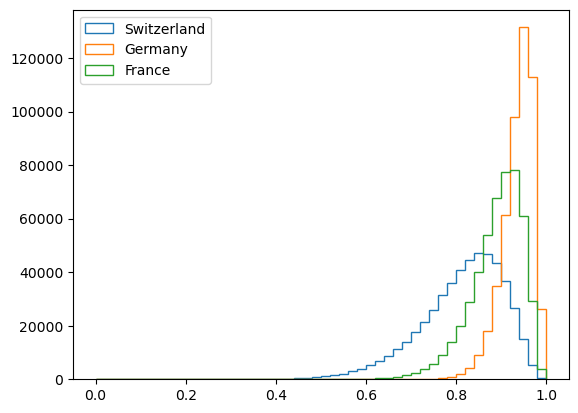

In [13]:
plt.hist(CH_correlations, range=(0,1), bins=50, histtype='step', label='Switzerland')
plt.hist(DE_correlations, range=(0,1), bins=50, histtype='step', label='Germany')
plt.hist(FR_correlations, range=(0,1), bins=50, histtype='step', label='France')
plt.legend()
plt.show()

The distribution of correlations differs between countries. This is due to the fact that the variance of the input data is different: larger countries have more 'averaged' load profiles, the variance is smaller, and therefore the correlation between synthetic series is larger.

This can be corrected by adjusting the standard deviation of the synthetic series.

Let us compute the pair-wise correlations for different values of the standard deviation:

In [14]:
std_scaling_values = np.exp(np.array(range(-20,21)) / 10)
CH_correlations_scaling = [ts.compute_pairwise_correlations(generate_time_series('CH', 1000, std_scaling=std_scaling)).mean()
                           for std_scaling in std_scaling_values]
DE_correlations_scaling = [ts.compute_pairwise_correlations(generate_time_series('DE', 1000, std_scaling=std_scaling)).mean()
                           for std_scaling in std_scaling_values]
FR_correlations_scaling = [ts.compute_pairwise_correlations(generate_time_series('FR', 1000, std_scaling=std_scaling)).mean()
                           for std_scaling in std_scaling_values]

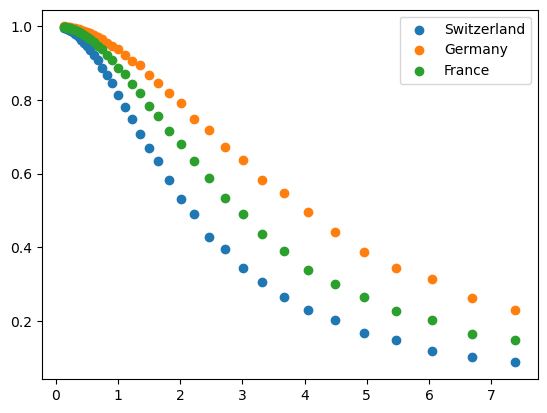

In [15]:
plt.scatter(std_scaling_values, CH_correlations_scaling, label='Switzerland')
plt.scatter(std_scaling_values, DE_correlations_scaling, label='Germany')
plt.scatter(std_scaling_values, FR_correlations_scaling, label='France')
plt.legend()
plt.show()

It turns out that these curves follow a simple pattern, given by
$$
y(x) = \frac{1}{1 + \rho x^2}
$$
with a different value of $\rho$ for each country, which can be computed from the distribution with normal scaling $y(1)$,
$$
\rho = \frac{1}{y(1)} - 1
$$

In [16]:
ρ_CH = 1 / CH_correlations.mean() - 1
ρ_DE = 1 / DE_correlations.mean() - 1
ρ_FR = 1 / FR_correlations.mean() - 1
ρ_CH, ρ_DE, ρ_FR

(0.2307821775505723, 0.06744780010472007, 0.12418709941256778)

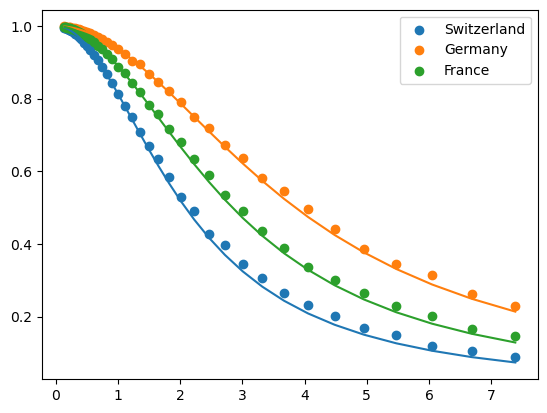

In [17]:
plt.plot(std_scaling_values, 1 / (1 + ρ_CH * std_scaling_values**2))
plt.plot(std_scaling_values, 1 / (1 + ρ_DE * std_scaling_values**2))
plt.plot(std_scaling_values, 1 / (1 + ρ_FR * std_scaling_values**2))
plt.scatter(std_scaling_values, CH_correlations_scaling, label='Switzerland')
plt.scatter(std_scaling_values, DE_correlations_scaling, label='Germany')
plt.scatter(std_scaling_values, FR_correlations_scaling, label='France')
plt.legend()
plt.show()

## Adjust correlations

Knowing the dependence of the pair-wise correlation on the standard deviation of the synthetic series, we can always adjust the latter to tune the former to a desired value.

In [18]:
mean_correlation_by_country = {country: ts.compute_pairwise_correlations(generate_time_series(country, 1000)).mean()
                               for country, time_series in loads_by_country.items()}

For instance, to get correlations of 0.8 on average, we should use the following list of standard deviations:

In [19]:
std_scaling_by_country = {country: np.sqrt((1 / 0.8 - 1) / (1 / mean_correlation - 1))
                          for country, mean_correlation in mean_correlation_by_country.items()}
std_scaling_by_country

{'ES': 1.4839904030259956,
 'FR': 1.413575580146391,
 'DE': 1.9013507376428436,
 'IT': 1.6958799884497944,
 'PL': 1.6515627298382296,
 'DK': 1.7687641964219136,
 'CH': 1.040136130944398,
 'PT': 1.655384010039155,
 'RO': 1.465779833140173,
 'AT': 1.5288096070783432,
 'CZ': 1.7811888476165858,
 'BG': 1.3166442270401506,
 'BE': 1.5618223809910583,
 'HU': 1.2171128745240525,
 'RS': 1.425613263569347,
 'SK': 1.3432564681317312,
 'GR': 1.1468080340032736,
 'NL': 1.1510768762089645,
 'BA': 0.5847970668227394,
 'HR': 1.4917818243800474,
 'SI': 1.2945199483024765,
 'ME': 1.0650250561238632}

Recompute loads series with this adjustment:

In [82]:
adjusted_loads_by_country = {country: generate_time_series(country, count, std_scaling_by_country[country])
                             for country, count in load_count_by_country.items()}

All series are now correlated in a similar way:

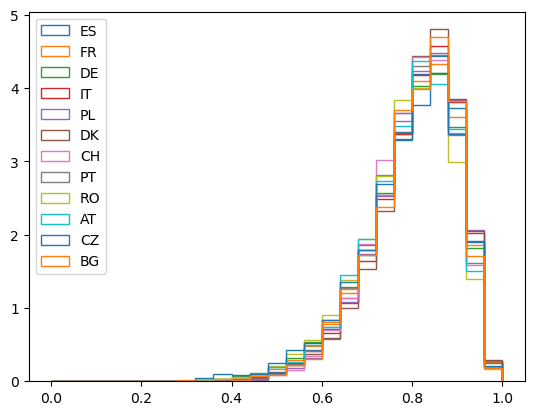

In [22]:
for country, time_series in adjusted_loads_by_country.items():
    if len(time_series) > 50:
        plt.hist(ts.compute_pairwise_correlations(time_series), range=(0,1), bins=25, histtype='step', density=True, label=country)
plt.legend()
plt.show()

Since each country's load profile has specific characteristics, the overall correlation between all time series has a broader distribution:

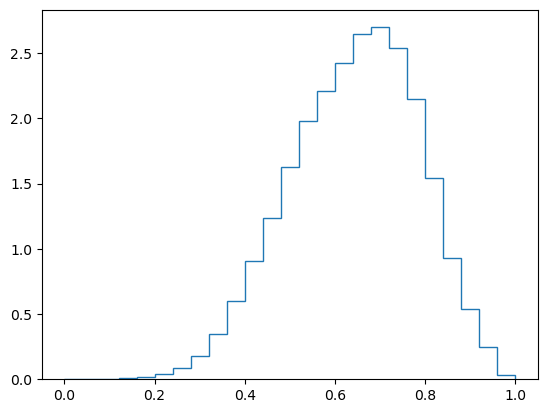

In [23]:
plt.hist(ts.compute_pairwise_correlations(np.concatenate(list(adjusted_loads_by_country.values()))),
         range=(0,1), bins=25, histtype='step', density=True)
plt.show()

### Export the time series

Combine all time series into an array:

In [83]:
all_time_series = np.array([load_prop * adjusted_loads_by_country[country][label]
                            for _, (id, country, load_prop, name, label) in loads_info.iterrows()])

In [84]:
assert all_time_series.shape == (n_loads, 364 * 24)

Define a dataframe containing all time series, with time steps as columns and loads as rows:

In [85]:
time_series_df = pd.DataFrame(all_time_series, index=loads_info["id"])
time_series_df

,0,1,2,3,4,5,6,7,8,9,...,8726,8727,8728,8729,8730,8731,8732,8733,8734,8735
id,,,,,,,,,,,,,,,,,,,,,
3935,117.840045,111.712556,111.104210,113.926103,120.250526,131.796803,145.747216,152.358000,154.331333,156.938709,...,130.634494,134.218955,142.472855,146.560659,145.202455,141.658417,135.899024,134.453541,126.776809,121.651265
2243,20.908900,20.509717,19.589803,19.161659,19.529880,20.870095,21.976906,23.036069,23.847711,24.366597,...,20.794136,20.696644,22.051200,23.655394,24.240320,23.516630,22.719529,22.797213,22.929277,23.318518
1881,63.651313,62.647224,59.642919,58.480239,61.308031,67.111806,73.005888,75.939522,76.945573,77.771360,...,63.576155,63.006865,66.914036,71.503721,72.901323,70.325205,67.273437,67.628872,67.587154,64.692268
1907,35.789844,35.173548,33.583355,32.608025,33.061603,34.642895,36.210048,37.128752,37.839585,38.691959,...,34.969505,34.811149,37.102496,39.882694,40.836327,39.695323,38.270979,38.751466,39.123961,38.225529
2923,37.989727,37.221963,35.118446,34.330421,36.017382,40.209978,44.895344,45.809014,45.322988,45.139287,...,37.736354,37.298746,39.547681,42.741122,43.666157,42.228560,40.131203,40.353649,41.284263,39.644913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,2.154030,2.029443,1.979704,1.963102,2.028260,2.205109,2.453162,2.646836,2.887693,3.093082,...,2.389363,2.343273,2.371575,2.587077,2.696304,2.785693,2.840720,2.818526,2.622070,2.357233
563,148.152801,139.189622,134.341976,132.695117,135.511992,144.024270,157.771290,170.003766,185.254430,191.354350,...,182.410247,176.990379,176.976140,190.588978,197.712513,202.971000,202.058220,192.649525,178.101478,162.208357
732,2.138793,2.136351,2.147883,2.161844,2.288336,2.543530,2.839462,3.027403,3.141412,3.205358,...,2.651884,2.767676,2.921766,2.794320,2.603504,2.529716,2.392936,2.336725,2.256092,2.160676


Export to CSV format:

In [86]:
time_series_df.to_csv("data/pantagruel_load_series.csv", mode='x')

The whole procedure can be iterated multiple times to generate more than one time series for each load.

## Generators

As with the loads, the list of generators of PanTaGruEl is stored in a CSV file:

In [87]:
gens_info = pd.read_csv('data/pantagruel_gen_info.csv')
gens_info

,id,type,pmax,country,name,cost
0,1,Hydro,1.14000,BG,Uzundzhovo,6000
1,519,hydro_pure_ps,11.64000,BE,Coo,10000
2,788,Geothermal,0.19000,IT,Montalto,0
3,774,fossil_brown_lignite,1.77000,HU,Tisza II,2400
4,599,Biomass,0.01902,FR,Beaucouze,1000
...,...,...,...,...,...,...
1078,732,nuclear,52.00000,FR,Cattenom,1600
1079,603,fossil_oil,14.15000,FR,Le Havre,10000
1080,414,other_nl,4.08000,RO,Brâila,1000
1081,710,fossil_coal_gas,1.53000,FR,Chapelle''d Arblay,11000


There are many "types" of generators and some are more descriptive than others. For instance, in some countries many generators are described as "Hydro", while in others the distinction is made between "hydro_pure_storage", "hydro_ror", and so on.

In [88]:
gen_types = set(gens_info['type'])
gen_types

{'Biomass',
 'Coal',
 'Gas',
 'Geothermal',
 'Hydro',
 'Nuclear',
 'Oil',
 'Waste',
 'biomass',
 'fossil_brown_lignite',
 'fossil_brown_lignite_cons',
 'fossil_coal_gas',
 'fossil_coal_gas_cons',
 'fossil_coal_hard',
 'fossil_mixed',
 'fossil_oil',
 'hydro_mixed',
 'hydro_mixed_cons',
 'hydro_pure_ps',
 'hydro_pure_storage',
 'hydro_pure_storage_cons',
 'hydro_ror',
 'nuclear',
 'nuclear_cons',
 'other_nl',
 'other_nrenew',
 'other_nrenew_cons',
 'waste_nr'}

Isolate all generators of hydraulic type:

In [89]:
hydro_types = {type for type in gen_types if 'hydro' in str.lower(type)}
hydro_types

{'Hydro',
 'hydro_mixed',
 'hydro_mixed_cons',
 'hydro_pure_ps',
 'hydro_pure_storage',
 'hydro_pure_storage_cons',
 'hydro_ror'}

In [90]:
hydro_gens_info = gens_info[gens_info['type'].isin(hydro_types)]
hydro_gens_info

,id,type,pmax,country,name,cost
0,1,Hydro,1.14000,BG,Uzundzhovo,6000
1,519,hydro_pure_ps,11.64000,BE,Coo,10000
5,491,hydro_ror,0.72300,AT,Pyhrn,1000
6,228,Hydro,0.16400,DE,Wengerohr,6000
9,227,Hydro,0.16400,DE,Wengerohr,6000
...,...,...,...,...,...,...
1070,1008,hydro_ror,5.95000,ES,Narcea,1000
1072,434,hydro_ror,1.38000,RO,Iaz,1000
1073,604,hydro_ror,0.96000,FR,St. Chamas,1000
1075,563,Hydro,0.01105,FR,Le Hourat,6000


Generate noise series with mean one and standard deviation 0.1:

In [91]:
noise_time_series = 1.0 + 0.1 * ts.generate_noise(count=len(hydro_gens_info))

In [92]:
noise_time_series.mean(), noise_time_series.std(axis=1).mean()

(1.0000000000000002, 0.09866128181625124)

Multiply with the static cost for each generator to obtain time series:

In [93]:
cost_time_series = noise_time_series * np.expand_dims(hydro_gens_info["cost"], axis=1)

Pack everything into a dataframe, with time steps as columns and generators as rows:

In [94]:
cost_time_series_df = pd.DataFrame(cost_time_series, index=hydro_gens_info["id"])
cost_time_series_df

,0,1,2,3,4,5,6,7,8,9,...,8726,8727,8728,8729,8730,8731,8732,8733,8734,8735
id,,,,,,,,,,,,,,,,,,,,,
1,5618.797288,5407.913229,5741.078543,5765.645843,6599.097045,6235.454825,5588.310137,6224.014204,6000.068322,5115.741089,...,5333.858722,4942.310248,6053.635778,6070.277847,5184.265961,4856.487202,5383.071904,4947.359251,4892.642727,6110.070236
519,9951.505501,9519.136802,9163.195296,10145.969834,9531.107937,9529.180395,9053.236616,9592.522750,9981.026465,8889.566625,...,9624.414544,7960.730826,8992.696307,10736.537652,9771.200947,9120.098767,10235.747464,10557.734325,10147.124534,9371.101723
491,929.736196,902.441347,873.526494,1061.636358,930.675707,941.692116,992.041784,890.324831,960.097418,968.290930,...,851.272336,965.973019,903.251827,930.212676,943.471499,947.568282,957.888252,931.478225,1022.788647,916.484261
228,6028.957943,5935.020292,6237.504706,6003.625162,6239.057721,6092.567047,6402.393606,5431.742162,5628.217263,6857.586511,...,5306.006558,5837.654446,5878.695165,5173.319180,5660.980437,5297.239876,5481.385359,6060.684618,5914.719532,6650.241988
227,6754.632628,6739.378480,6639.427438,5729.140919,6067.034513,6615.306482,6147.897543,6511.050725,5809.872717,6028.275951,...,5742.320921,6567.802945,6338.955331,6600.812684,6450.138640,6329.827731,6425.189286,6461.333085,6288.223309,6378.027429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,880.144492,800.831357,996.729857,1003.621089,1019.047542,1032.794947,982.467674,1059.190832,1010.747872,902.607024,...,885.003916,729.947727,879.225918,905.214403,766.765039,1021.790271,1043.421269,840.423645,892.859301,1024.737364
434,1031.066047,936.215865,941.206728,978.106713,934.498742,1057.209246,1111.562194,919.926110,973.449645,1114.036953,...,987.491553,1034.984259,934.036092,984.223562,1086.764477,913.737433,920.886166,1116.543663,1034.582884,990.696471
604,913.887152,875.040283,854.603439,877.939856,879.190189,875.460389,927.100801,827.178996,947.858359,1014.019088,...,837.494935,702.175019,934.843285,845.878100,841.940591,853.885700,815.332521,911.060198,772.987415,811.500005


Export to CSV format:

In [95]:
cost_time_series_df.to_csv('data/pantagruel_hydro_cost_series.csv', mode='x')

If all generators have a variable production cost, not only the hydraulic ones, then we can use:

In [139]:
noise_time_series = 1.0 + 0.1 * ts.generate_noise(count=len(gens_info))

In [140]:
cost_time_series = noise_time_series * np.expand_dims(gens_info["cost"], axis=1)

In [141]:
cost_time_series_df = pd.DataFrame(cost_time_series, index=gens_info["id"])
cost_time_series_df

,0,1,2,3,4,5,6,7,8,9,...,8726,8727,8728,8729,8730,8731,8732,8733,8734,8735
id,,,,,,,,,,,,,,,,,,,,,
1,5705.069503,5657.261839,5645.516183,6132.554097,5718.574405,6094.255857,5607.217160,5374.796729,6008.733613,4800.768312,...,5876.689768,6285.991491,5735.914461,5375.999098,6317.903157,5475.351737,5913.781203,6288.950845,5984.449878,5805.024720
519,10306.207985,9922.704882,10304.616377,10975.036762,9053.993535,8257.704708,8637.926210,10789.867403,11647.703431,10820.751061,...,11827.916897,11563.412344,11139.988593,11147.168123,10132.469745,11296.019280,11673.917351,11287.238267,10864.798625,9468.534167
788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
774,2439.308686,2372.152384,2443.680317,2387.331334,2357.538367,2603.973583,2141.571972,2301.937816,2041.901999,2181.623813,...,2518.697733,2781.065305,2473.188219,2866.488739,2402.009376,2588.860345,2477.951189,2253.266354,2595.454004,2258.950250
599,1052.540641,1035.976070,944.590023,1006.441826,989.243884,920.280094,882.691980,917.544421,841.743548,866.837329,...,1004.607352,1121.076018,1058.344356,1019.549823,1046.504427,1078.321887,1009.429759,1020.861893,956.963960,861.729066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,1599.014840,1525.015048,1552.656893,1719.785733,1654.826236,1655.988972,1801.808140,1663.721428,1663.734970,1942.015096,...,1469.928729,1564.556402,1697.164743,1587.103468,1523.254576,1479.754051,1449.671124,1492.048458,1496.389173,1529.446562
603,8408.269023,7585.308678,7988.955628,8456.088076,8368.745754,7787.948982,7402.358286,7648.869800,7663.152433,8870.120364,...,9430.469278,7878.539463,7229.949251,8815.644016,8354.795798,9314.316999,8401.984086,7800.174557,8634.332156,8482.230018
414,1119.101430,1156.865428,1093.010050,990.473883,1108.351003,1076.398747,1037.816255,1126.769148,1137.291544,1127.942871,...,954.802010,955.118624,1031.647502,1012.495968,971.169170,918.479567,1009.010487,1081.357257,1047.686919,1110.836472


In [142]:
cost_time_series_df.to_csv('data/pantagruel_gen_cost_series.csv', mode='x')